# Estimation and Classification Course: Mini-Project
**Authors**: Kevin Alcedo & Dinis Miranda

## Description

We simulate a robot navigating a gridworld with obstacles and estimate the global (map) position from local (sensor) observations.

## Approach
- Gridworld: 
    - encapsulated as a Gym.Environment [1]
    - generated with random obstacles
    - corresponding transition and observation matrices are calculated
    - state transitions are determinisitic, only free-cells (non-obstacles are valid)
    - observations are deterministic (no sensor noise) 
- Robot motion:
    - robot follows a uniform random policy over observable valid actions:
    - i.e the robot only considers moving towards free-cells it observes. 
    - since the robot has limited sensing (NSEW) it may consider an invalid action (all eight neighbors including 'stay in place')
    - if an invalid action is taken, the environment prevents the robot from moving; i.e the robot stays in place
- Robot perception:
    - robot perceives obstacles in NSEW 
    - observations are modeled as a binary vector
- Self-localization:
    - We model the robot dynamics as an HMM
    - We estimate the probability distribution of the robot on the grid at time $t$ using the backward-forward algorithm
    - At every step we keep track of the history of observations and recompute the most-likely state
- Visualization
    - On the left: 
        - grid with robot ground-truth position
        - probability distribution superimposed over the grid-cells
    - On the right:
        - egocentric observations

In [ ]:
# python modules
from os import environ 
from importlib import reload

environ['PYGAME_HIDE_SUPPORT_PROMPT'] = '1' # used to hide pygame initial prompt

# project specific modules
import environment
import policy
import utils
import localization

# third-party dependencies
import gymnasium as gym
from gymnasium.envs.registration import register
from IPython.display import HTML
from IPython.display import Image

# reload modules in jupyter notebook when prototyping
# reload(environment)
# reload(policy)
# reload(utils)
# reload(localization)


## Example

This is a run using fake probabilities, for more details check out `utils.simulate_dummy_scenario()`

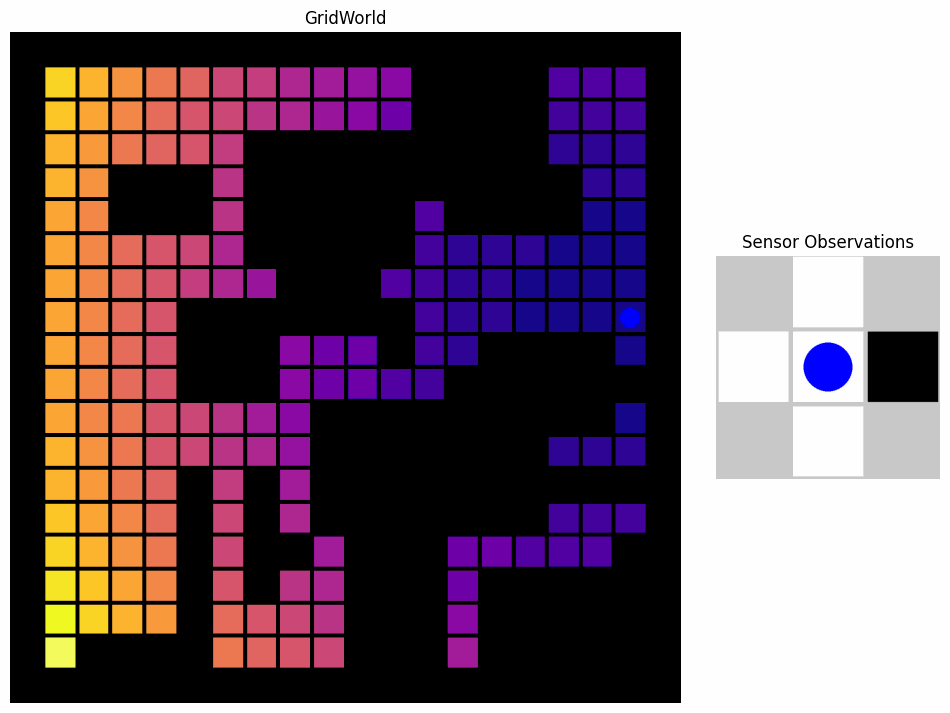

In [3]:
save_animation_to_path = 'figures/sample.gif'
utils.simulate_dummy_scenario(save_to_path=save_animation_to_path)
# display below
with open(save_animation_to_path,'rb') as f:
    display(Image(data=f.read(), format='png'))

## To Complete

The code below shows the structure on how to run the simulator and where to implement the Hidden Markov Model (HMM) for localization. 

HMM should be implemented in `localization.py`.

`get_state_probabilities` is the main method to be implemented located in the `localization` module.

The HMM implementation will require the following inputs:
- observation: 
    - a vector of data type numpy array, with dimensions: (4,)
- transition_matrix $T$: 
    - a matrix of data type numpy array, with dimensions: $(N \times N) \times (N \times N)$
- observation_matrix $O$: 
    - a matrix of data type numpy array, with dimensions: $(N \times N) \times Z$
    - $Z$ is the unique observations possible in the grid from valid cells. 
    - In our scenario we know the upper bound is $2^4=16$
    - Since an observation is a binary vector of length four [N,S,E,W]; since each value can be $\{0,1\}$, then $2^4=16$
    - For example, in the case of $N=20$, and $Z=16$, $O$ will be $400 \times 16$
- observation_history: 
    - list of all observations so far

THE HMM implementation should output:
- state probabilities: a vector of data type numpy array, with dimensions: $(N \times N)$

In [4]:
# load environment 
gridworld_dimensions = 20
obstacle_ratio = 0.4
max_steps = 100
result_save_path = 'figures/results.gif'

env = utils.load_env(gridworld_dimensions, obstacle_ratio)

# load robot motion controller
robot = policy.RandomActionAgent()

# generate a new world
observation, T, O, info = env.reset()

# init state probabilities 
num_states = info['num_states']
init_probs = localization.init_probabilities(num_states=num_states)

# generate initial frame
frame = env.render(state_probabilities=init_probs)
frames = [frame]

obs_history = [observation]

# simulate multiple steps
for t in range(1,max_steps):
    # robot observes and takes an action
    action = robot.act(observation)
    # step environment with action and receive new observations
    observation, _, _, _, info = env.step(action=action)

    # compute new probabilities
    probs_t = localization.get_state_probabilities(observation=observation,
                                                 transition_matrix=T,
                                                 observation_matrix=O,
                                                 observation_history=obs_history)
    # generate new frame
    frame = env.render(state_probabilities=probs_t)
    frames.append(frame)

    obs_history.append(observation)

# save frames to gif
environment.save_gif(frames, save_to_path=result_save_path)

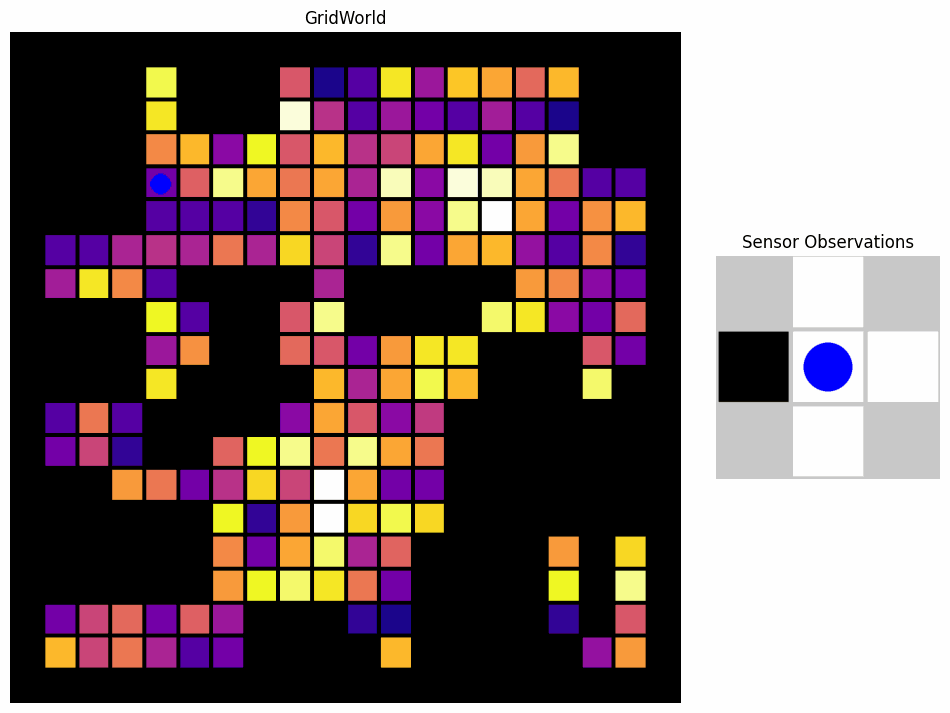

In [5]:
# display result
with open(result_save_path,'rb') as f:
    display(Image(data=f.read(), format='png'))

## References
- [Farama Gym Env](https://gymnasium.farama.org/)
